# EDA 

**Summary**

In this notebook we will create a dataframe composed of the file path names of each audio file and its corresponding target class {'major': 0, 'minor': 1}. This dataframe will be used in a for loop to preprocess the audio data into spectrograms. We will also explore the characteristics of raw audio files, spectrograms, and image files, to understand the fundamental differences between feeding spectrograms or images into a convolutional neural network. 


In [25]:
# IMPORTS 
# for data manipulation 
import pandas as pd
import numpy as np
from numpy import asarray
import matplotlib.pylab as plt 
from matplotlib.pylab import imshow

# to read file paths 
import os

# to manipulate sound files 
import librosa 
from librosa.display import waveshow
from IPython.display import Audio

# to manipulate image files 
from PIL import Image

In [26]:
# checking file path names 
os.listdir('../audio_files')

['Major', 'Minor']

In [27]:
# Assigning file paths into two separate list classes 
maj = os.listdir('../audio_files/Major')
minor = os.listdir('../audio_files/Minor')

In [28]:
print(f'Audio Files (Major): {len(maj)}, Audio Files (Minor): {len(minor)}')
total = len(maj) + len(minor)
print(f'Total Audio Files: {total}')
print(f'Percent of Major: {len(maj)/total}')
print(f'Percent of Minor: {len(minor)/total}')

Audio Files (Major): 502, Audio Files (Minor): 357
Total Audio Files: 859
Percent of Major: 0.5844004656577415
Percent of Minor: 0.41559953434225844


#### We can see that we have a total of 859 unique audio files and a distribution of 

Major: 58.4%

Minor: 41.6%

**Null-Baseline** = 58.4%

In [29]:
# Creating dataframe out of the audio file paths. Ensuring index is False so we don't have two starting points for our index.
# If index = True, the index would start from 0-501 then to 0-356. 
audio_files = pd.concat([pd.DataFrame({'chord_qual': maj, 'target': 0}), 
pd.DataFrame({'chord_qual': minor, 'target': 1})], ignore_index=True)
audio_files.to_csv('audio_files.csv', index=False)

In [30]:
# We can see no null values and the correct dtypes for our columns
audio_files.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 859 entries, 0 to 858
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   chord_qual  859 non-null    object
 1   target      859 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 13.6+ KB


In [31]:
audio_files

,chord_qual,target
0,Major_500.wav,0
1,Major_266.wav,0
2,Major_272.wav,0
3,Major_299.wav,0
4,Major_474.wav,0
...,...,...
854,Minor_215.wav,1
855,Minor_201.wav,1
856,Minor_229.wav,1
857,Minor_23.wav,1


## Observe Raw Audio 

In [32]:
def raw_audio_vis(file_path, chord_qual):
    if chord_qual == 0:
        sig, sr = librosa.load(f'../audio_files/Major/{file_path}', sr=22050, mono=True, duration=10)
    elif chord_qual == 1:
         sig, sr = librosa.load(f'../audio_files/Minor/{file_path}', sr=22050, mono=True, duration=10)
    
    fig, ax = plt.subplots(nrows=2, sharex=True, sharey=True)
    librosa.display.waveshow(sig, sr=sr, ax=ax[0])
    ax[0].set(title='Monophonic')
    ax[0].label_outer()
    ax[0].set_ylabel('Amplitude')
    
    y_harm, y_perc = librosa.effects.hpss(sig)
    librosa.display.waveshow(y_harm, sr=sr, alpha=0.25, ax=ax[1])
    librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[1])
    ax[1].set(title='Harmonic + Percussive')
    ax[1].set_ylabel('Amplitude')



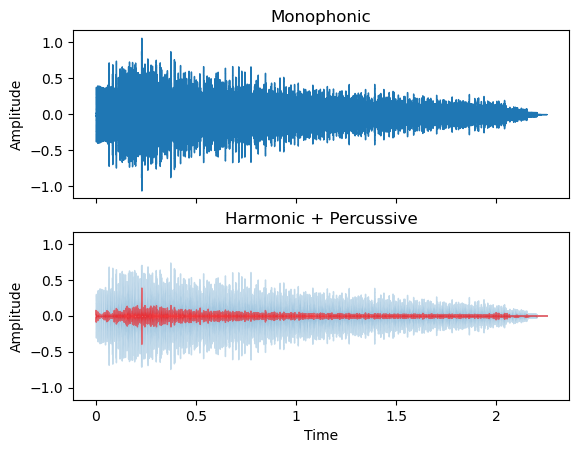

In [33]:
raw_audio_vis(audio_files['chord_qual'][555], 1)
plt.savefig('../images/raw_audio.jpg')

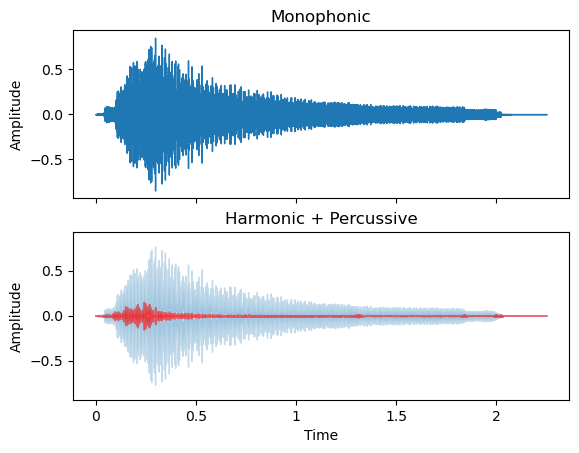

In [34]:
raw_audio_vis(audio_files['chord_qual'][22], 0)
plt.savefig('../images/02_raw_audio.jpg')

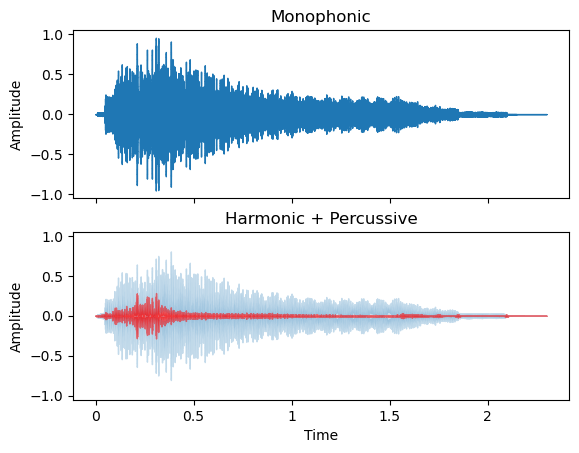

In [11]:
raw_audio_vis(audio_files['chord_qual'][801], 1)

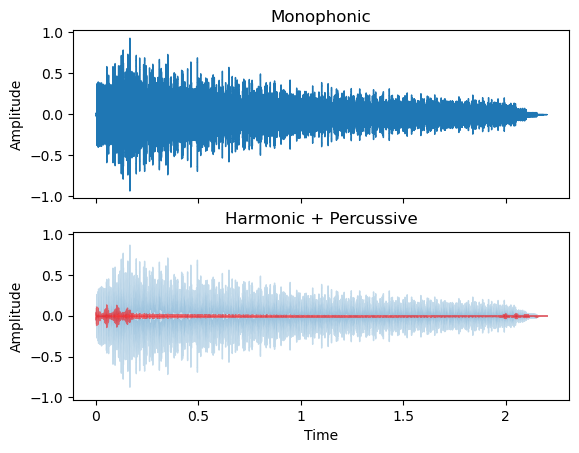

In [12]:
raw_audio_vis(audio_files['chord_qual'][405], 0)

## Interpretation of Raw Audio Visuals

By randomly sampling four audio files we can observe any anomalies or similarities in the raw audio visuals. The raw audio visuals show amplitude (y-axis) of sound over time (x-axis). We can see that all transients have one initial peak and wane from there. This indicates that there is only one strike of the chord for each file. We can also see little percussive elements in our audio. Opposed to the initial strike of the chord there are no follow up indications of rhythm. We can also see there was no time shifting augmentation on these audio files because the highest transients always start from the beginning. We will make sure to implement random time shifting to extract more data to feed into the model. We can also see most audio files lose most amplitude by the two second mark. During preprocessing we will set the length of the audio file to a set length. 


---

## Checking Chord Quality

We will randomly open up and listen to two major chords and two minor chords. We will break down the notes of the chord and determine its chord quality. This is a check to make sure our audio files were properly labeled and a chance to explore the variety of chord **inversions** and **extensions** that were used. 


**Inversions** : Fundamentally a chord is constructed out of the first, third, fifth, and seventh note of a seven note scale. Inversions are different ways to order a chord. Here are the most basic examples of chord inversions. 

- Root Position = 1, 3, 5, 7
- 1rst Inversion = 3, 5, 7, 1
- 2nd Inversion = 5, 7, 1, 3
- 3rd Inversion = 7, 1, 3, 5

**Extensions** : Are added notes to chords that are not the fundamental 1st, 3rd, 5th, and 7th notes of the seven note scale. Most common extensions are 9th (2nd note of scale up an octave) and 11th(4th note up an octave).

An example would be **audio_file_4** which is a F Minor 9th chord.

- Notes of Scale: 1_F, 2_G, 3_Ab, 4_Bb, 5_C, 6_D, 7_Eb
- Notes of Chord: F, Ab, C, Eb, G
- Numeric Quality of Notes: 1, 3, 5, 7, 9


In [13]:
aud_file = '../audio_files/Major/Major_20.wav'
aud_file_2 = '../audio_files/Major/Major_476.wav'
aud_file_3 = '../audio_files/Minor/Minor_277.wav'
aud_file_4 = '../audio_files/Minor/Minor_113.wav'
aud_file_5 = '../audio_files/Minor/Minor_119.wav'

print('Db Major 7th Chord')
print('Note Order: Db-Ab-C-F')
print('Expected Chord Quality = True')
display(Audio(aud_file))

Db Major 7th Chord
Note Order: Db-Ab-C-F
Expected Chord Quality = True


- This Db Major 7th chord is clear and is a good example of a Major audio file 

In [14]:
print('Bb Major 6th Chord')
print('Note Order: Bb-D-F-G')
print('Expected Chord Quality = True')
display(Audio(aud_file_2))

Bb Major 6th Chord
Note Order: Bb-D-F-G
Expected Chord Quality = True


- This (Bb Major 6th: Bb-D-F-G) chord will be difficult for our models to interpret. This is because all of the notes that go into a Major 6th chord are the same notes that go into it's relative Minor 7th chord (G Minor 7th: G-Bb-D-F). The ability to determine the difference between a Major 6th and it's relative Minor 7th chord is either a different instrument establishing the root or the context of the chords before and after it. Because we don't have these features to use in our models it seems that our models will be thrown off by this data. We can also notice inversions used in some of these audio files. This means that a G Minor 7th chord could validly have the notes ordered as (Bb-D-F-G) just as our Bb Major 6th chord is labeled. 
- For future consideration new data should be created or found with simpler chord structures and chord qualities that do not match even in inversions. 

In [15]:
print('Eb Minor 7th Chord')
print('Note Order: Eb-Bb-Db-Gb')
print('Expected Chord Quality = True')
display(Audio(aud_file_3))

Eb Minor 7th Chord
Note Order: Eb-Bb-Db-Gb
Expected Chord Quality = True


- This Eb Minor 7th chord is clear and is a good example of a Major audio file 

In [16]:
print('F Minor 9th Chord')
print('Note Order: F-Ab-C-Eb-G')
print('Expected Chord Quality = True')
display(Audio(aud_file_4))

F Minor 9th Chord
Note Order: F-Ab-C-Eb-G
Expected Chord Quality = True


- This F Minor 9th Chord is clear and shows no conflict with other chord qualities.

In [17]:
print('F Diminished Triad')
print('Note Order: F-Ab-B-F')
print('Expected Chord Quality = False')
display(Audio(aud_file_5))

F Diminished Triad
Note Order: F-Ab-B-F
Expected Chord Quality = False



- This F Diminished Triad does not match either chord quality classes. This is a diminished chord and distinctly different from the quality it was labeled as (minor). This is a mislabeled class and will impact the quality of our model. 
- Future consideration will be to locate other data that is properly labeled or create an original dataset with simpler chord qualities. 


---

## Differences Between Spectrograms and Images

In [37]:
aud = '../audio_files/Minor/Minor_18.wav'

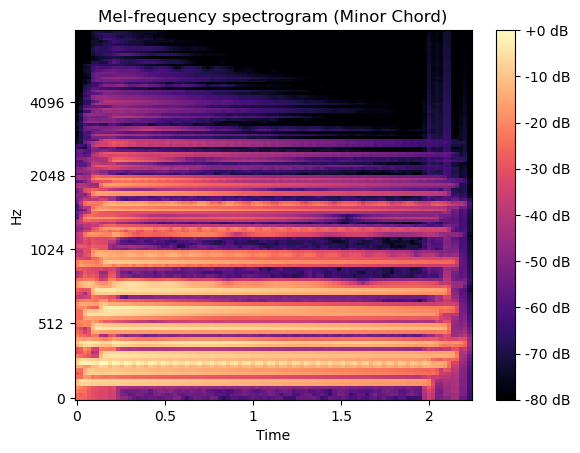

In [38]:
sig, sr = librosa.load(aud, sr=22050, mono=True)
S = librosa.feature.melspectrogram(y=sig, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max) 

fig, ax = plt.subplots()
img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram (Minor Chord)');
plt.savefig('../images/minor_mel_spec.jpg')

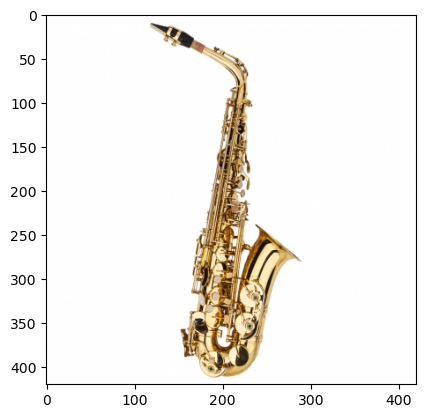

In [20]:
img = Image.open('../images/saxophone.jpg')
imshow(img);

In [21]:
img.size, S_dB.shape

((420, 420), (128, 100))

In [22]:
data = asarray(img)
print(f'The data type for this image is {type(data)}')
print(f'The data type for this spectrogram is {type(data)}')

The data type for this image is <class 'numpy.ndarray'>
The data type for this spectrogram is <class 'numpy.ndarray'>


In [23]:
print(data)

[[[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [254 254 254]
  [255 255 255]
  [254 254 254]]

 [[253 253 253]
  [254 254 254]
  [254 254 254]
  ...
  [254 254 254]
  [255 255 255]
  [254 254 254]]

 ...

 [[255 255 255]
  [254 254 254]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[254 254 254]
  [253 253 253]
  [255 255 255]
  ...
  [254 254 254]
  [254 254 254]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [254 254 254]
  ...
  [254 254 254]
  [254 254 254]
  [255 255 255]]]


In [24]:
print(S_dB)

[[-24.433163 -25.408321 -28.73313  ... -50.378857 -58.542343 -80.      ]
 [-23.823242 -27.19295  -26.493473 ... -51.46541  -59.117897 -80.      ]
 [-20.886484 -23.68272  -25.375536 ... -53.079887 -59.975178 -80.      ]
 ...
 [-80.       -80.       -79.387054 ... -79.5813   -80.       -80.      ]
 [-80.       -80.       -80.       ... -79.441345 -80.       -80.      ]
 [-80.       -80.       -80.       ... -79.20574  -80.       -80.      ]]


### Similarities 

- Both images and spectrograms have a data type of an ndarray from numpy. 

### Differences 

- For images, the weights on the x and y axis are the same. Every point on an image represents a pixel intensity. For spectrograms, the x and y axis are fundamentally different. The x-axis represents time and the y_axis represents amplitude and frequency. This means that models will respond differently if a spectrogram is rotated. If the x-axis is now vertical, the model won't be able to adjust the axis observation. 
- Neighboring pixels in an image can strongly be assumed to be a part of the same object. However in spectrograms frequencies aren't separated by different objects but clumped together in a time-series. This means that a CNN model will have a harder time identifying separate sounds. 
